In [51]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from tqdm import tqdm
from torchsummary import summary

import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms


import torch.backends.cudnn as cudnn
cudnn.benchmark = True

# Define the module path so that we can call our own helper functions
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.utilities.utils import get_image_paths

## 2.1-Model-Training

After assessing the best model to use from the previous notebook, we are going to train the mobilenet_v3_s model. While the efficientnet model did perform slightly better,the mobilenet_v3_s model wasn't far off in performance and had less than half the parameters of the efficientnet model. In this instance, we will choose to train the mobilenet model, as it has a similar performance to the efficientnet model and at more than half the size


## Data Preprocessing

I have included some logical augmentations into the preprocessing pipeline. These include random rotation of about +/- 30 deg and random horizontal flip. While other augmentations such as Augmix, adjustsharpness etc. can be used. Due to limited time, we will just explore these. In reality, an iterative approach would be explored to see which augmentations are constructive and destructive to the model"s training.

In [2]:
data_dir = os.path.join(module_path, "data", "processed")


In [3]:
# Data resizing, augmentation and normalization. Just resizing and normalization for validation set
data_transforms = {
    "train": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-30, 30)),
        transforms.ToTensor(),
        transforms.Normalize([0.4519, 0.3799, 0.3389], [0.2496, 0.2254, 0.2166])
    ]),
    "val": transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.4519, 0.3799, 0.3389], [0.2496, 0.2254, 0.2166])
    ]),
}
        

In [17]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ["train", "val"]}


In [18]:
# dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4) for x in ["train", "val"]}
train_loader = DataLoader(image_datasets["train"], batch_size=32, num_workers=4, shuffle=True)
val_loader = DataLoader(image_datasets["val"], batch_size=32, num_workers=4, shuffle=False)


In [19]:
dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}


In [20]:
class_names = image_datasets["train"].classes


In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


### Visualize a few images from dataset

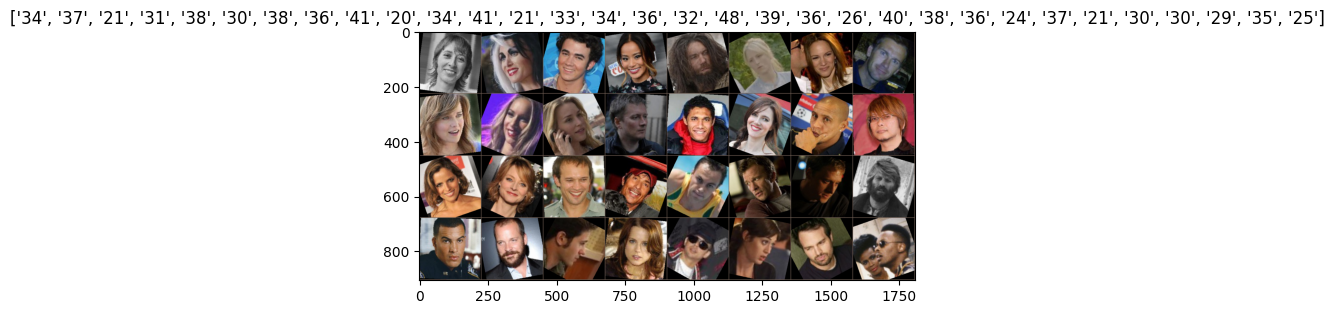

In [43]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.4519, 0.3799, 0.3389])
    std = np.array([0.2496, 0.2254, 0.2166])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
# inputs, classes = next(iter(dataloaders["train"]))
inputs, classes = next(iter(train_loader))


# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Load Pretrained Model

In [23]:
model = models.mobilenet_v3_small(pretrained=True)


C:\Users\Jared\anaconda3\envs\braineye\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\Jared\anaconda3\envs\braineye\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [25]:
# Modify the final layer to output a single value for regression
num_ftrs = model.classifier[3].in_features
model.classifier[3] = nn.Linear(num_ftrs, 1)
model = model.to(device)



### Define Loss and Optimzier

In [36]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Regularization term
l1_lambda = 0.001

### Define learning rate scheduler



In [30]:
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [38]:
num_epochs = 20
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in tqdm(train_loader, total=len(train_loader)):
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # L1 Regularization - Encourage sparsity and hopefully set some weights to zero
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss = loss + l1_lambda * l1_norm
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    train_losses.append(running_loss / len(train_loader))
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, total=len(val_loader)):
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1).float()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    val_losses.append(val_loss / len(val_loader))
    print(f"Validation Loss: {val_loss/len(val_loader)}")


100%|██████████| 733/733 [00:43<00:00, 16.87it/s]


Epoch 1/20, Loss: 111.04668947977063


100%|██████████| 184/184 [00:12<00:00, 14.27it/s]


Validation Loss: 44.01873558500539


100%|██████████| 733/733 [00:43<00:00, 16.76it/s]


Epoch 2/20, Loss: 94.45291313598133


100%|██████████| 184/184 [00:12<00:00, 14.33it/s]


Validation Loss: 44.61474184886269


100%|██████████| 733/733 [00:44<00:00, 16.47it/s]


Epoch 3/20, Loss: 86.56070867436969


100%|██████████| 184/184 [00:13<00:00, 14.07it/s]


Validation Loss: 45.62093860688417


100%|██████████| 733/733 [00:45<00:00, 16.18it/s]


Epoch 4/20, Loss: 81.00742848020296


100%|██████████| 184/184 [00:13<00:00, 13.87it/s]


Validation Loss: 45.176527723022126


100%|██████████| 733/733 [00:44<00:00, 16.55it/s]


Epoch 5/20, Loss: 77.31576411623259


100%|██████████| 184/184 [00:12<00:00, 14.26it/s]


Validation Loss: 44.227889631105505


100%|██████████| 733/733 [00:44<00:00, 16.30it/s]


Epoch 6/20, Loss: 74.43391893602816


100%|██████████| 184/184 [00:12<00:00, 14.19it/s]


Validation Loss: 48.577134505562164


100%|██████████| 733/733 [00:43<00:00, 16.90it/s]


Epoch 7/20, Loss: 72.01879622080804


100%|██████████| 184/184 [00:12<00:00, 14.19it/s]


Validation Loss: 47.22442875219428


100%|██████████| 733/733 [00:45<00:00, 16.23it/s]


Epoch 8/20, Loss: 69.62818526701257


100%|██████████| 184/184 [00:13<00:00, 14.01it/s]


Validation Loss: 44.52118723807128


100%|██████████| 733/733 [00:44<00:00, 16.51it/s]


Epoch 9/20, Loss: 68.302256965377


100%|██████████| 184/184 [00:12<00:00, 14.29it/s]


Validation Loss: 46.706755073174186


100%|██████████| 733/733 [00:43<00:00, 16.69it/s]


Epoch 10/20, Loss: 66.12390722194115


100%|██████████| 184/184 [00:14<00:00, 12.53it/s]


Validation Loss: 44.911675396172896


100%|██████████| 733/733 [00:44<00:00, 16.31it/s]


Epoch 11/20, Loss: 65.23130010940531


100%|██████████| 184/184 [00:14<00:00, 12.83it/s]


Validation Loss: 49.287456289581634


100%|██████████| 733/733 [00:45<00:00, 16.15it/s]


Epoch 12/20, Loss: 63.87925012960603


100%|██████████| 184/184 [00:12<00:00, 14.25it/s]


Validation Loss: 45.764799429022744


100%|██████████| 733/733 [00:44<00:00, 16.50it/s]


Epoch 13/20, Loss: 62.83405381498037


100%|██████████| 184/184 [00:13<00:00, 13.68it/s]


Validation Loss: 47.70158559343089


100%|██████████| 733/733 [00:43<00:00, 16.83it/s]


Epoch 14/20, Loss: 61.773638570455056


100%|██████████| 184/184 [00:12<00:00, 14.26it/s]


Validation Loss: 49.66206938287486


100%|██████████| 733/733 [00:44<00:00, 16.40it/s]


Epoch 15/20, Loss: 60.56370578261059


100%|██████████| 184/184 [00:13<00:00, 14.07it/s]


Validation Loss: 46.26358163356781


100%|██████████| 733/733 [00:43<00:00, 16.97it/s]


Epoch 16/20, Loss: 59.494266520418215


100%|██████████| 184/184 [00:13<00:00, 13.61it/s]


Validation Loss: 44.339260920234345


100%|██████████| 733/733 [00:44<00:00, 16.51it/s]


Epoch 17/20, Loss: 58.80426755023035


100%|██████████| 184/184 [00:12<00:00, 14.63it/s]


Validation Loss: 45.404899949612826


100%|██████████| 733/733 [00:42<00:00, 17.06it/s]


Epoch 18/20, Loss: 58.08267460155617


100%|██████████| 184/184 [00:12<00:00, 14.25it/s]


Validation Loss: 44.171148714811906


100%|██████████| 733/733 [00:43<00:00, 16.71it/s]


Epoch 19/20, Loss: 57.29756066711342


100%|██████████| 184/184 [00:12<00:00, 14.55it/s]


Validation Loss: 45.585900094198145


100%|██████████| 733/733 [00:44<00:00, 16.54it/s]


Epoch 20/20, Loss: 56.52800959421863


100%|██████████| 184/184 [00:13<00:00, 14.12it/s]

Validation Loss: 46.25892516841059


### Plot training and validation loss

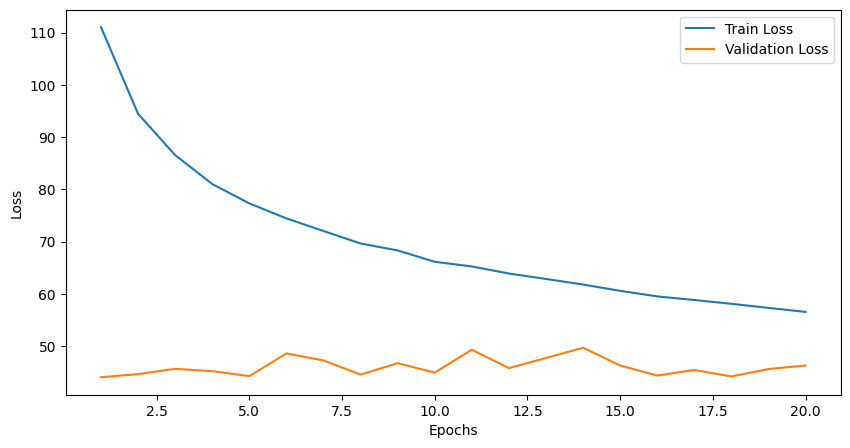

In [39]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


### Visualize Predictions vs. Actuals

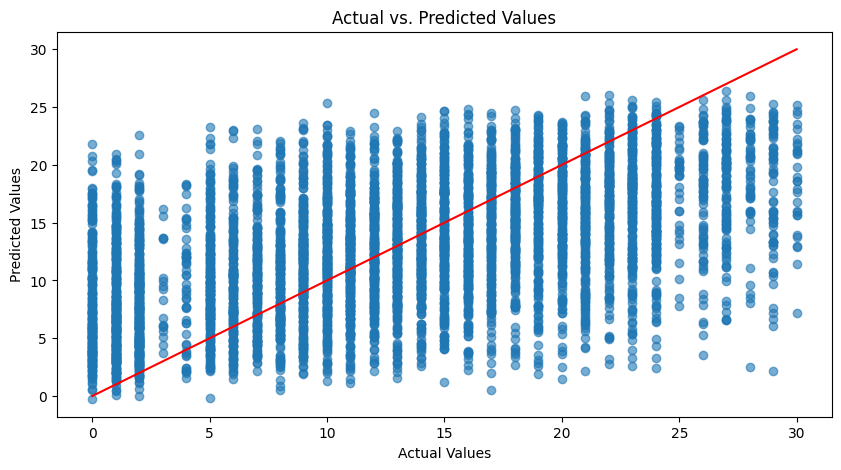

In [40]:
model.eval()
actuals = []
predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
        outputs = model(inputs)
        actuals.extend(labels.cpu().numpy())
        predictions.extend(outputs.cpu().numpy())

plt.figure(figsize=(10, 5))
plt.scatter(actuals, predictions, alpha=0.6)
plt.plot([min(actuals), max(actuals)], [min(actuals), max(actuals)], 'r')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


### Model Summary

In [92]:
model_summary = model.to(device)
summary(model_summary, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             432
       BatchNorm2d-2         [-1, 16, 112, 112]              32
         Hardswish-3         [-1, 16, 112, 112]               0
            Conv2d-4           [-1, 16, 56, 56]             144
       BatchNorm2d-5           [-1, 16, 56, 56]              32
              ReLU-6           [-1, 16, 56, 56]               0
 AdaptiveAvgPool2d-7             [-1, 16, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             136
              ReLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 16, 1, 1]             144
      Hardsigmoid-11             [-1, 16, 1, 1]               0
SqueezeExcitation-12           [-1, 16, 56, 56]               0
           Conv2d-13           [-1, 16, 56, 56]             256
      BatchNorm2d-14           [-1, 16,

## Serialize Model (before model optimization)

In [48]:
model_path = os.path.join(module_path, "models", "mobilenet_v3_small_regression_l1.pth")
torch.save(model.state_dict(), model_path)


## Pruning

When it comes to pruning a model, there are many different strategies. For one, one person can prune their model before training, whereas, another way could be pruning after training. For our purpose, we will prune after and test the performance of the model after.

In [73]:
# Pruning function - doesn't work??
def apply_pruning(model, amount=0.5):
    """
    Prune the model by removing a fraction of the parameters.

    Args:
        model: The model to be pruned.
        amount: Fraction of parameters to prune (e.g., 0.5 means 50%).
    """
    # Ensure the model is in eval mode
    model.eval()
    
    # Apply pruning to all Conv2D and Linear layers
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.l1_unstructured(module, name='weight', amount=amount)

    # Apply pruning to BatchNorm2d layers if necessary
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            prune.l1_unstructured(module, name='weight', amount=amount)

    # Remove pruning reparametrization (make pruning permanent)
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Linear)):
            prune.remove(module, 'weight')
            
    return model

In [90]:
pruned_model = apply_pruning(model, amount=0.9)



In [91]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Parameters before pruning: {count_parameters(model)}")
print(f"Parameters after pruning: {count_parameters(pruned_model)}")

Parameters before pruning: 1518881
Parameters after pruning: 1518881


In [80]:
for name, module in model.named_modules():
    pass

print(f"{module}")

Linear(in_features=1024, out_features=1, bias=True)


In [86]:
# print(list(module.named_parameters()))
print(module.weight)

Parameter containing:
tensor([[0., -0., -0.,  ..., -0., -0., 0.]], device='cuda:0',
       requires_grad=True)


## Optimizing for Mobile Deployment

While the prune functions above aren't performing as intended, I have proceeded forward for the last step. For this, while it was originally desired to explore quantization to reduce the precision of the weights and activations to further reduce the model size and improve the inference time, I failed toget this working in time. That said, since we are using PyTorch, let's convert the model to TorchScript to prepare for mobile deployment.




In [110]:
def convert_to_torchscript(model):
    model.eval()
    # Use tracing or scripting to convert the model
    traced_model = torch.jit.trace(model, torch.randn(1, 3, 224, 224))
    return traced_model

In [111]:
scripted_model = convert_to_torchscript(model)  # Convert to TorchScript


In [116]:
mobile_model_path = os.path.join(module_path, "models", "mobilenet_v3_small_regression_l1_mobile.pt")

torch.jit.save(scripted_model, mobile_model_path)